# Анализ вакансий
**Часть 4**
## Удаление выбросов
Поскольку требования были получены из текстов вакансий, написанных отделами кадров, данные по своей природе содержат шумы (выбросы). Ранее мы извлекли элементы списков из объявлений о вакансиях, полагая, что эти элементы, скорее всего, являются требованиями, но, конечно, могут быть чем-то еще.
Для удаления выбросов была использована кластеризация по методу DBSCAN, среди преимуществ которого:
- DBSCAN не требует спецификации числа кластеров в данных;
- DBSCAN может найти кластеры произвольной формы;
- DBSCAN имеет понятие шума и может выделять выбросы.
Однако DBSCAN хорошо работает только в пространстве объектов малой размерности. Для уменьшения размерности использовался метод UMAP.
Алгоритмы уменьшения размерности UMAP и кластеризации DBSCAN  позволяют нам выполнять автоматизированную очистку данных, удаляя большинство выбросов.

На предыдущих  этапах были выполнены следующие действия:
- извлечение требований;
- получение эмбедингов предложений (S-Bert).

На этом этапе будет выполнено:
- уменьшение размерности (umap);
 - кластеризация на основе плотности (DBSCAN).

# 1. Служебный код
## 1.1. Импорт
### 1.1.1. Импорт библиотек

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
pd.options.plotting.backend = "plotly" #interactive plots will be useful in this context
import plotly.express as px
import seaborn as sns
import numpy as np
from importlib import reload
from sentence_transformers import SentenceTransformer, util
import torch
import umap
from datetime import datetime
from sklearn.cluster import DBSCAN
import plotly.graph_objects as go
from collections import Counter
import warnings

### 1.1.2. Импорт модулей

In [2]:
import config
reload(config)
from config import settings

import scripts.utils.files as files
reload(files)

import scripts.model_scripts.text_process as proc
reload(proc)

import scripts.model_scripts.cluster_utils as cu
reload(cu)


<module 'scripts.model_scripts.text_process' from '/mnt/data/projects/active/urfu/vkr/scripts/model_scripts/text_process.py'>

## 1.2. Настройка параметров

In [3]:
pd.set_option("display.max_rows", 20)
pd.set_option("display.max_columns", 20)
pd.set_option("display.precision",6)
sns.set_style("ticks",{'axes.grid' : True})
warnings.simplefilter("ignore")

#Для корректного отображения графиков в ноутбуках используется команда %matplotlib inline
%matplotlib inline
# для корректного отображения графиков на тёмном фоне
plt.style.use('default')

In [4]:
MODEL_SUBDIR = settings.get_fresh('BLOCK_MODELING_SUBDIR')
PROCESSED_SUBDIR = settings.get_fresh('PROCESSED_LOCAL_SUBDIR')
NLTK_DIR  = settings.get_fresh('NLTK_DIR')
FILENAME_EMB_SUFFIX = settings.get_fresh('FILENAME_EMB_SUFFIX')
FILENAME_UMAP_SUFFIX = settings.get_fresh('FILENAME_UMAP_SUFFIX')
FILENAME_DBSCAN_SUFFIX = settings.get_fresh('FILENAME_DBSCAN_SUFFIX')
FILENAME_BLOCK_REDUCER_MODEL= settings.get_fresh('FILENAME_BLOCK_REDUCER_MODEL')
FILENAME_REQUIREMENT_VECTORIZATION_MODEL= settings.get_fresh('FILENAME_REQUIREMENT_VECTORIZATION_MODEL')

In [5]:
# model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')
# model = SentenceTransformer('sentence-transformers/distiluse-base-multilingual-cased-v2')
# model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-mpnet-base-v2')
# model = SentenceTransformer('sentence-transformers/stsb-xlm-r-multilingual')
# model = SentenceTransformer('sentence-transformers/paraphrase-xlm-r-multilingual-v1')
# model = SentenceTransformer('sentence-transformers/distilbert-multilingual-nli-stsb-quora-ranking')
# model = SentenceTransformer('sentence-transformers/quora-distilbert-multilingual')
# model = SentenceTransformer('sentence-transformers/use-cmlm-multilingual')

MODEL1_NAME='paraphrase_minilm_l12'
MODEL2_NAME= 'distiluse_cased_v2'
MODEL3_NAME='paraphrase_mpnet_v2'
MODEL4_NAME='stsb_xlm_r'

MODELS = {MODEL1_NAME:
              'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2',
       MODEL2_NAME:
             'sentence-transformers/distiluse-base-multilingual-cased-v2',
         MODEL3_NAME:
              'sentence-transformers/paraphrase-multilingual-mpnet-base-v2',
         MODEL4_NAME:
              'sentence-transformers/stsb-xlm-r-multilingual'}

N_COMPONENTS=[2, 3, 4]

In [6]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())

True
1
0


In [7]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

# 2. Загрузка данных и общее описание набора данных
## 2.1. Загрузка данных

In [8]:
requirements_filename = settings.get_fresh('FILENAME_REQUIREMENTS_TOKENIZED')
requirements_dict=files.load_data_dump(requirements_filename, MODEL_SUBDIR)

In [9]:
df = pd.DataFrame.from_dict(requirements_dict, "index")
df.reset_index(inplace=True)
df.rename(columns={'index':'code'}, inplace=True)

## 2.2. Информация о наборе данных

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 669431 entries, 0 to 669430
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   code       669431 non-null  object
 1   count      669431 non-null  int64 
 2   canonical  669431 non-null  object
 3   unigrams   669431 non-null  object
 4   bigrams    669431 non-null  object
 5   trigrams   669431 non-null  object
dtypes: int64(1), object(5)
memory usage: 30.6+ MB


In [11]:
df.head()

,code,count,canonical,unigrams,bigrams,trigrams
0,опыт_взаимодействие_команда_разработка,42,опыт взаимодействия с командой разработки,"[опыт, взаимодействие, команда, разработка]","[(опыт, взаимодействие), (взаимодействие, кома...","[(опыт, взаимодействие, команда), (взаимодейст..."
1,опыт_работа_реляционный_бд_sql_формирование_по...,1,опыт работы с реляционными БД SQL для формиров...,"[опыт, работа, реляционный, бд, sql, формирова...","[(опыт, работа), (работа, реляционный), (реляц...","[(опыт, работа, реляционный), (работа, реляцио..."
2,опыт_работа_функциональный_требование_формиров...,1,опыт работы с функциональными требования для ф...,"[опыт, работа, функциональный, требование, фор...","[(опыт, работа), (работа, функциональный), (фу...","[(опыт, работа, функциональный), (работа, функ..."
3,опыт_подготовка_проектный_документация_техниче...,1,опыт подготовки проектной документации техниче...,"[опыт, подготовка, проектный, документация, те...","[(опыт, подготовка), (подготовка, проектный), ...","[(опыт, подготовка, проектный), (подготовка, п..."
4,операционный_инструкция,15,операционные инструкции,"[операционный, инструкция]","[(операционный, инструкция)]",[]


Датасет содержит набор выражений, представляющих собой синтаксически выделенные требования к соискателю.

# 3. Обработка выбросов

## 3.1. Векторизация выражений
Первый этап - это получение векторных представлений для выражений, представляющих собой синтаксически выделенное требование к соискателю.
Sentence-transformers — это библиотека, предоставляющая простые методы вычисления вложений (плотных векторных представлений) для предложений, абзацев и изображений.
Тексты встраиваются в векторное пространство таким образом, чтобы похожие тексты располагались близко друг к другу. Это позволяет использовать такие приложения, как семантический поиск, кластеризация и извлечение данных.
Выбор модели осуществляется пользователем под свои нужды, в данном случае используется многоязыковая модель так как требуется анализировать текст, содержащий русский язык

In [19]:
print(datetime.now())
# Выбрать вариант с нормализацией и без
requirements = df.canonical.tolist()
# requirements =df['unigrams'].apply(proc.join_unigrams).tolist()

for m_key in MODELS:
   model = SentenceTransformer(MODELS[m_key])
   print('encoding '+m_key + str(datetime.now()))
   embeddings = model.encode(requirements, device=DEVICE)
   # Сохранение данных
   filename = f'{m_key}_{FILENAME_EMB_SUFFIX}'
   processed_data_file_path = files.save_data_dump(embeddings, filename, MODEL_SUBDIR)
   # Сохранение модели
   filename = f'{m_key}_{FILENAME_REQUIREMENT_VECTORIZATION_MODEL}'
   files.save_model(model, filename)
   print('done'+m_key+str(datetime.now()))
print(datetime.now())

2024-05-16 01:27:35.847118


encoding paraphrase_minilm_l122024-05-16 01:34:09.276325
doneparaphrase_minilm_l122024-05-16 01:36:46.857080


encoding distiluse_cased_v22024-05-16 01:44:11.838865
donedistiluse_cased_v22024-05-16 01:47:52.662397


encoding paraphrase_mpnet_v22024-05-16 02:03:08.169757
doneparaphrase_mpnet_v22024-05-16 02:09:06.916273


encoding stsb_xlm_r2024-05-16 02:24:23.298753
donestsb_xlm_r2024-05-16 02:30:20.555869
2024-05-16 02:30:20.556054


Извлечение embeddings с помощью pickle (распаковка результата приведенного выше блока кода)

In [10]:
embeddings={}
for m_key in MODELS:
    filename = f'{m_key}_{FILENAME_EMB_SUFFIX}'
    embeddings[m_key]=files.load_data_dump(filename, MODEL_SUBDIR)

Размерность эмбедингов:

In [11]:
for m_key in MODELS:
    print(embeddings[m_key].shape)

(669431, 384)
(669431, 512)
(669431, 768)
(669431, 768)


## 3.2. Уменьшение размерности эмбедингов предложений
Эмбединги предложений, загруженные в блоке выше, имеют высокую размерность (от 384 до 768 измерений). DBSCAN плохо работает с такой высокой размерностью. На следующем шаге размерность уменьшается с помощью UMAP.

In [14]:
def umap_reduce_embedding(vectors, n_components=2):
    '''
    Функция, которая использует набор векторизованных навыков и возвращает векторы, уменьшенные до n измерений
    :param vectors: векторы, для которых требуется выполнить преобразование
    :param n_components: требуемое количество компонент (измерений)
    :return: новый вектор, уменьшенный до n измерений
    '''
    reducer = umap.UMAP(random_state=1, n_jobs=6, n_components=n_components)
    umap_embeddings = reducer.fit_transform(vectors)
    return reducer, umap_embeddings

Уменьшение размеров с помощью umap

In [19]:
umap_embeddings={}
for m_key in MODELS:
    n_embeddings={}
    for n in N_COMPONENTS:
        reducer, n_embeddings[n]=umap_reduce_embedding(embeddings[m_key], n)
        print(f'n= {n}')
        print(n_embeddings[n].shape)
        # Сохранение данных
        filename = f'{m_key}_{n}_{FILENAME_UMAP_SUFFIX}'
        processed_data_file_path = files.save_data_dump(n_embeddings[n], filename, MODEL_SUBDIR)
        # Сохранение модели
        filename = f'{m_key}_{n}_{FILENAME_BLOCK_REDUCER_MODEL}'
        files.save_model(reducer, filename)
        print('Сохранено: '+ filename)
    umap_embeddings[m_key]=n_embeddings

n= 2
(669431, 2)
Сохранено: paraphrase_minilm_l12_2_umap
n= 3
(669431, 3)
Сохранено: paraphrase_minilm_l12_3_umap
n= 4
(669431, 4)
Сохранено: paraphrase_minilm_l12_4_umap
n= 2
(669431, 2)
Сохранено: distiluse_cased_v2_2_umap
n= 3
(669431, 3)
Сохранено: distiluse_cased_v2_3_umap
n= 4
(669431, 4)
Сохранено: distiluse_cased_v2_4_umap
n= 2
(669431, 2)
Сохранено: paraphrase_mpnet_v2_2_umap
n= 3
(669431, 3)
Сохранено: paraphrase_mpnet_v2_3_umap
n= 4
(669431, 4)
Сохранено: paraphrase_mpnet_v2_4_umap
n= 2
(669431, 2)
Сохранено: stsb_xlm_r_2_umap
n= 3
(669431, 3)
Сохранено: stsb_xlm_r_3_umap
n= 4
(669431, 4)
Сохранено: stsb_xlm_r_4_umap


Загрузка уменьшенных эмбедингов

In [12]:
umap_embeddings={}
for m_key in MODELS:
    n_embeddings={}
    for n in N_COMPONENTS:
        filename = f'{m_key}_{n}_{FILENAME_UMAP_SUFFIX}'
        n_embeddings[n]=files.load_data_dump(filename, MODEL_SUBDIR)
    umap_embeddings[m_key]=n_embeddings

## 3.3. Определение параметров алгоритма DBSCAN
Для DBSCAN основными гиперпараметрами на входе являются:
- радиус окрестности – eps;
 - минимальное количество точек, которое может быть в одном кластере (соседей) – minpt.
Количество соседей принимается из расчета minpt>n+1, где n - размерность данных. Однако, если принять во внимание большой объем исходного набора данных, наличие данных с шумом и дубликатов, кластер с количеством точек меньше 20, можно считать шумом (выбрано эмпирически).
Для того, чтобы понять, какую окрестность выбрать, необходимо понять, как близко расположены точки в  наборе данных. Для этого сначала рассчитаем среднее расстояние по minpt ближайшим соседям для каждой точки.

In [19]:
from sklearn.neighbors import NearestNeighbors

minpt=20
neighbors={}
for m_key in MODELS:
    n_neighbors={}
    for n in N_COMPONENTS:
        X = umap_embeddings[m_key][n]
        nbrs = NearestNeighbors(n_neighbors=minpt+1, algorithm='ball_tree', metric='euclidean', n_jobs=1).fit(X)
        n_neighbors[n] = np.sort([np.mean(nbrs.kneighbors([x])[0][0, 1:]) for x in X])

    neighbors[m_key]=n_neighbors

In [21]:
filename = 'neighbors'
processed_data_file_path = files.save_data_dump(neighbors, filename, MODEL_SUBDIR)
print(processed_data_file_path)

/mnt/data/projects/active/urfu/vkr/data/block_modeling/neighbors.dmp


In [12]:
filename = 'neighbors'
neighbors = files.load_data_dump(filename, MODEL_SUBDIR)

Графики среднего  расстояния по minpt ближайшим соседям для каждой точки:

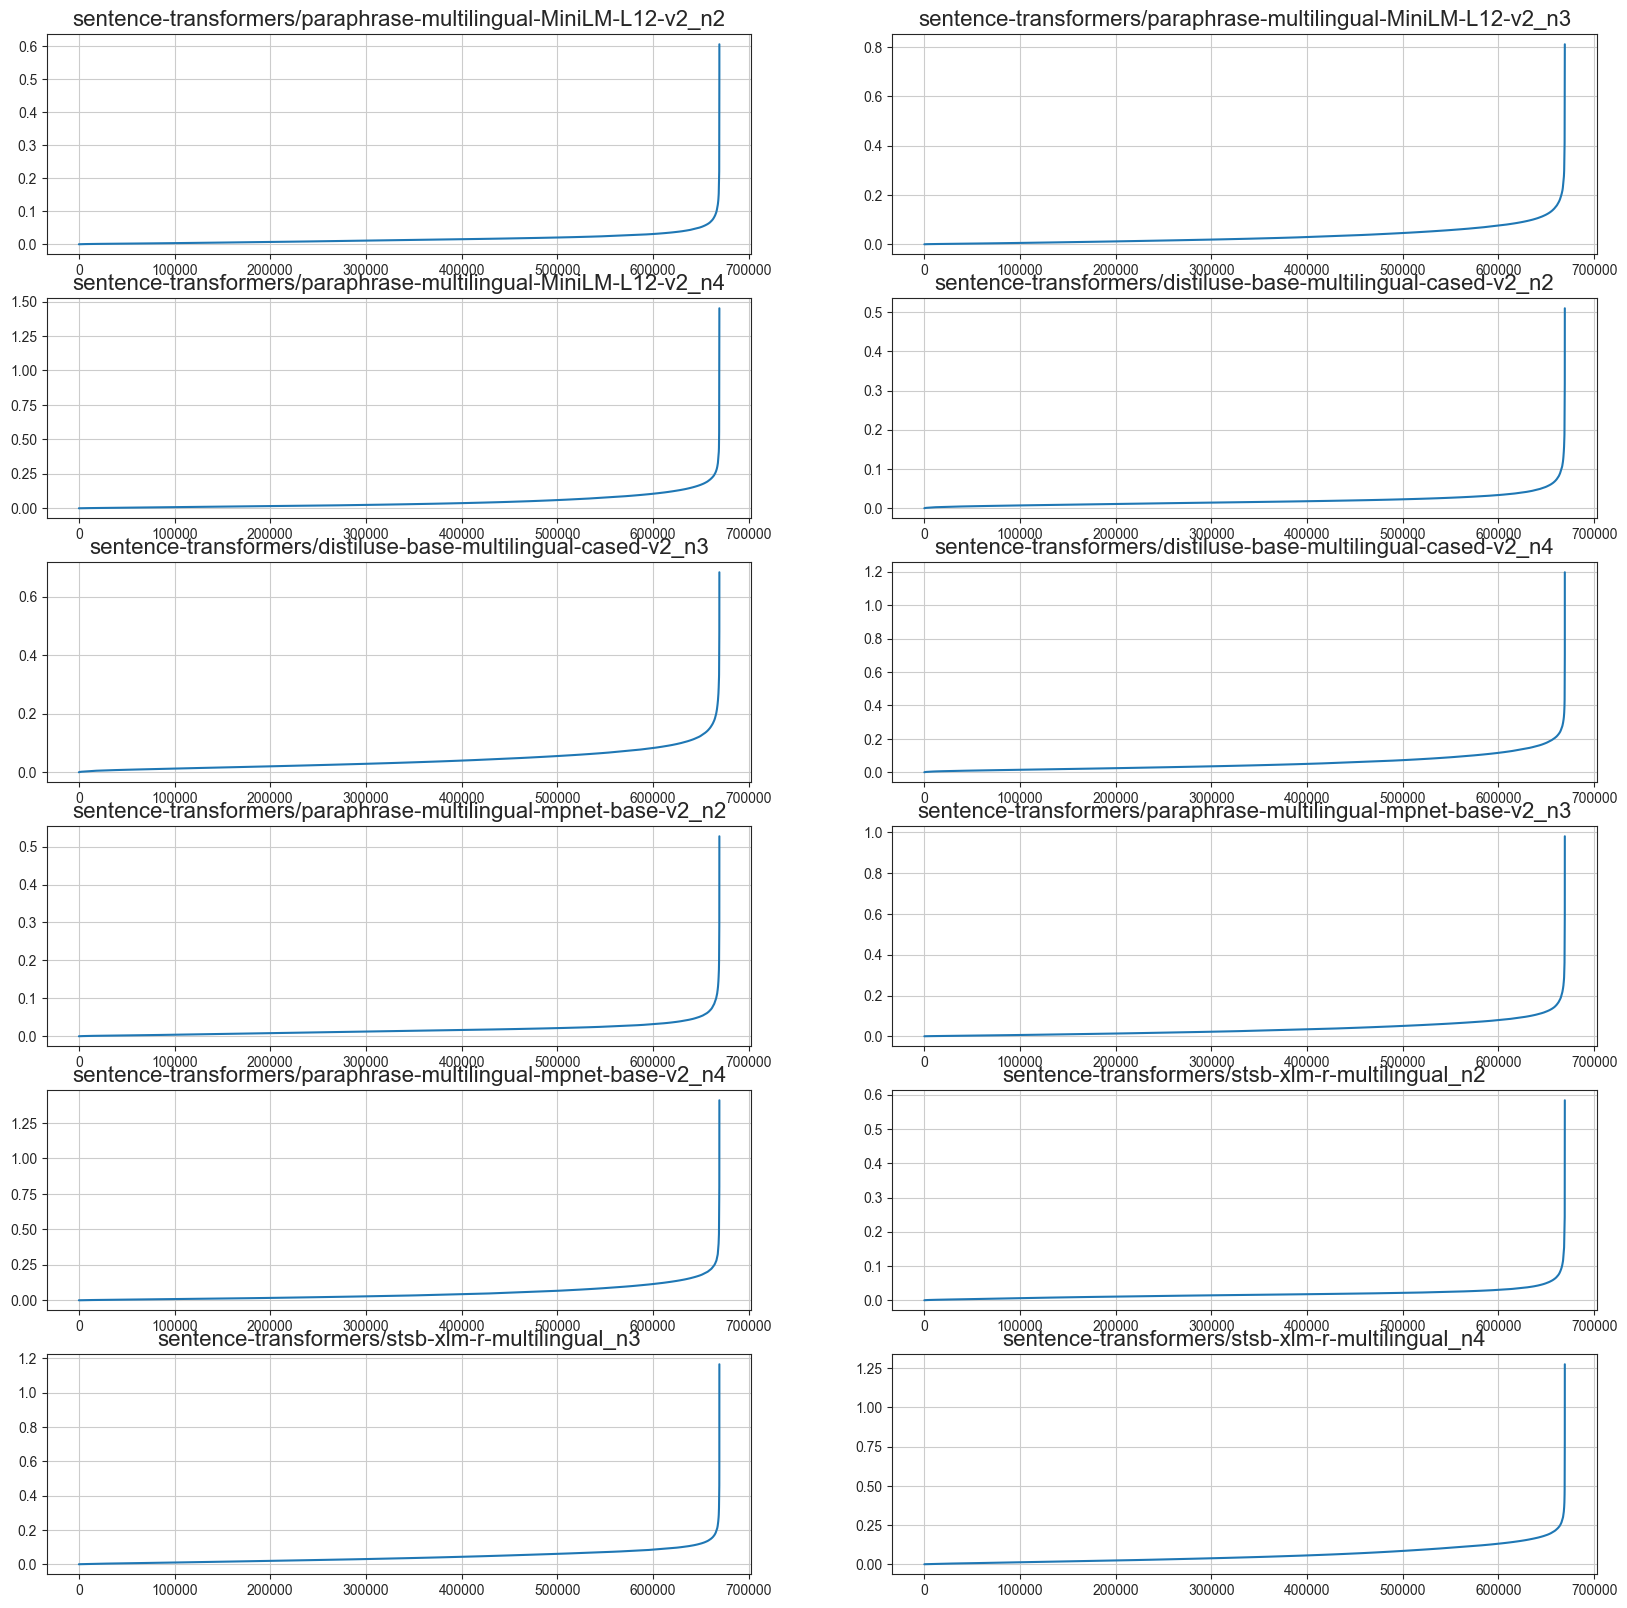

In [30]:
sns.set_style("ticks",{'axes.grid' : True})
total=len(N_COMPONENTS)*len(MODELS)
_cols = 2
_rows = int(np.ceil(total / _cols))
num=-1
fig, ax = plt.subplots(nrows=_rows, ncols=_cols, figsize=(20, 20))
ax = ax.flatten()
x=range(len(df))
for m_key in MODELS:
    for n in N_COMPONENTS:
            num = num+1
            (sns.lineplot(y=neighbors[m_key][n], x=x, ax=ax[num])
             .set_title(f'{MODELS[m_key]}_n{n}', fontsize=16)
             .set_y('среднее расстояние') )

На основе анализа графиков отсортированных по возрастанию значений расстояния были выбраны следующие значения eps:

In [13]:
dbscan_params={
    MODEL1_NAME:{
        2:{'eps':0.1, 'min_samples':20},
        3:{'eps':0.2, 'min_samples':20},
        4:{'eps':0.25, 'min_samples':20},},
    MODEL2_NAME:{
        2:{'eps':0.1, 'min_samples':20},
        3:{'eps':0.2, 'min_samples':20},
        4:{'eps':0.3, 'min_samples':20},},
    MODEL3_NAME:{
        2:{'eps':0.1, 'min_samples':20},
        3:{'eps':0.2, 'min_samples':20},
        4:{'eps':0.3, 'min_samples':20},},
    MODEL4_NAME:{
        2:{'eps':0.1, 'min_samples':20},
        3:{'eps':0.2, 'min_samples':20},
        4:{'eps':0.3, 'min_samples':20},}
}

## 3.4. Кластеризация с использованием алгоритма DBSCAN
Выполнена кластеризация на основе плотности (DBSCAN) для различных моделей векторизации предложений.
Результаты для каждой модели показаны на  ниже.

In [32]:
dbscan_embeddings={}

for m_key in MODELS:
    n_embeddings={}
    for n in N_COMPONENTS:
        eps=dbscan_params[m_key][n]['eps']
        min_samples=dbscan_params[m_key][n]['min_samples']
        dbscaned = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=6).fit(umap_embeddings[m_key][n])
        n_embeddings[n] = dbscaned

        # df[f'{m_key}_{n}_dbscan_0']=dbscaned.labels_
        # df[f'{m_key}_{n}_dbscan_1']= dbscaned.labels_.astype(str)

        filename = f'{m_key}_{n}_{FILENAME_DBSCAN_SUFFIX}'
        processed_data_file_path = files.save_data_dump(dbscaned, filename, MODEL_SUBDIR)
        print('Сохранено: '+ filename)

    dbscan_embeddings[m_key]=n_embeddings

Сохранено: paraphrase_minilm_l12_2_dbscan
Сохранено: paraphrase_minilm_l12_3_dbscan
Сохранено: paraphrase_minilm_l12_4_dbscan
Сохранено: distiluse_cased_v2_2_dbscan
Сохранено: distiluse_cased_v2_3_dbscan
Сохранено: distiluse_cased_v2_4_dbscan
Сохранено: paraphrase_mpnet_v2_2_dbscan
Сохранено: paraphrase_mpnet_v2_3_dbscan
Сохранено: paraphrase_mpnet_v2_4_dbscan
Сохранено: stsb_xlm_r_2_dbscan
Сохранено: stsb_xlm_r_3_dbscan
Сохранено: stsb_xlm_r_4_dbscan


In [13]:
# Загрузка данных кластерного анализа
dbscan_embeddings={}

for m_key in MODELS:
        n_embeddings={}
        for n in N_COMPONENTS:
            filename = f'{m_key}_{n}_{FILENAME_DBSCAN_SUFFIX}'
            n_embeddings[n] = files.load_data_dump(filename, MODEL_SUBDIR)
            # df[f'{m_key}_{n}_dbscan_0']=n_embeddings[n].labels_
            # df[f'{m_key}_{n}_dbscan_1']=n_embeddings[n].labels_.astype(str)
        dbscan_embeddings[m_key]=n_embeddings

Количество полученных кластеров для каждой модели:

In [34]:
for m_key in MODELS:
    for n in N_COMPONENTS:
        X=dbscan_embeddings[m_key][n]
        labels = X.labels_
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise_ = list(labels).count(-1)
        counter=Counter(labels).most_common()

        print(f'\nМодель: {MODELS[m_key]}')
        print(f'\nКоличество измерений: {n}')
        print("Всего кластеров: %d" % n_clusters_)
        print("Точек, попавших в шум: %d" % n_noise_)
        print(f"Самый большой кластер: {counter[0][0]}, точек в нем: {counter[0][1]}" )
        print(f"Самый маленький кластер: {counter[-1][0]}, точек в нем: {counter[-1][1]}" )


Модель: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2

Количество измерений: 2
Всего кластеров: 1077
Точек, попавших в шум: 4073
Самый большой кластер: 0, точек в нем: 306763
Самый маленький кластер: 1073, точек в нем: 6

Модель: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2

Количество измерений: 3
Всего кластеров: 934
Точек, попавших в шум: 3843
Самый большой кластер: 0, точек в нем: 289035
Самый маленький кластер: 933, точек в нем: 19

Модель: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2

Количество измерений: 4
Всего кластеров: 857
Точек, попавших в шум: 4533
Самый большой кластер: 0, точек в нем: 277023
Самый маленький кластер: 846, точек в нем: 19

Модель: sentence-transformers/distiluse-base-multilingual-cased-v2

Количество измерений: 2
Всего кластеров: 308
Точек, попавших в шум: 3066
Самый большой кластер: 0, точек в нем: 352948
Самый маленький кластер: 294, точек в нем: 17

Модель: sentence-transformers/distiluse-base-multilingual-c

In [31]:
def plot_clusters(m_key):
    fig = px.scatter(df,f'{m_key}_umap_0', f'{m_key}_umap_1', hover_data = ['canonical'], title = f"Pre-trained Model:{MODELS[m_key]}",color = f'{m_key}_dbscan_1')
    fig.update_traces(marker=dict(size=2.5), opacity=0.3)
    fig.update_layout(margin=go.layout.Margin(l=1, r=0,b=0, t=45 ),
                         plot_bgcolor = 'rgb(240,245,255)',
                         xaxis_title="",
                         yaxis_title="",
                         font=dict(size=20),
                         showlegend = False
                         #yaxis_tickformat = '%'
                         )
    return fig
    # fig.write_image('../survey_plots/umap_all_distilroberta_v1_embeddings.pdf')

In [14]:
def plot_clusters2(mkey, nn):
    plt.figure(figsize=(8, 4))
    x=umap_embeddings[mkey][nn][:,0]
    y=umap_embeddings[mkey][nn][:,1]
    z=dbscan_embeddings[mkey][nn].labels_.astype(str)
    sns.scatterplot(x=x, y= y, hue=z,  legend=None) #.set_title(f'{MODELS[mkey]}_n{nn}', fontsize=16)
    plt.title(f'{MODELS[mkey]}_n{nn}', fontsize=16)
    plt.ylabel('u2', fontsize=12)
    plt.xlabel('u1', fontsize=12)
    plt.show()

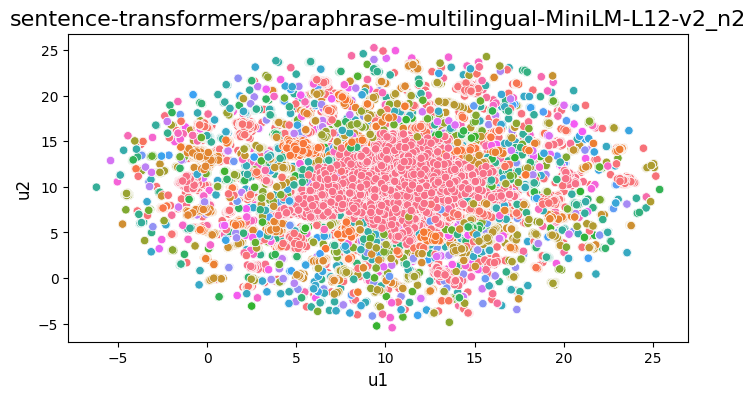

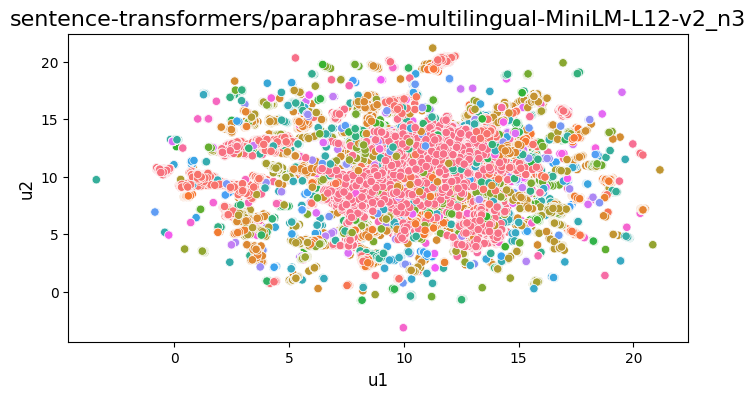

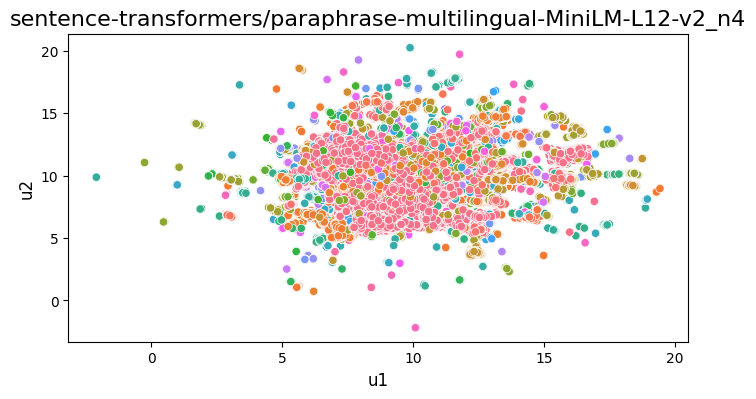

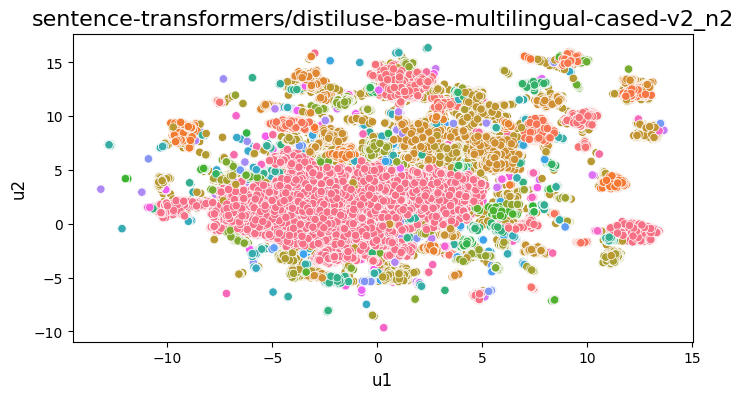

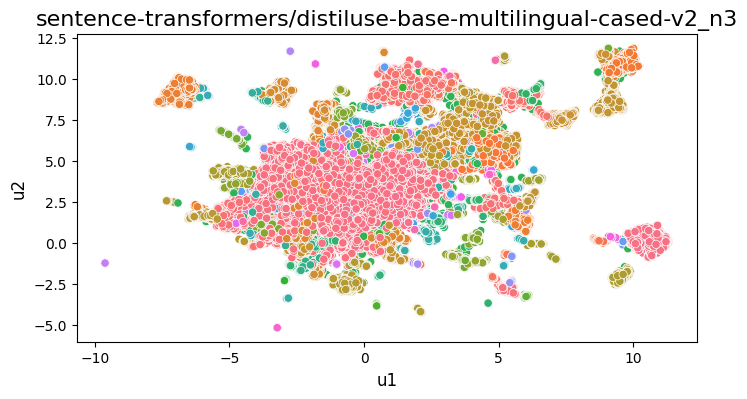

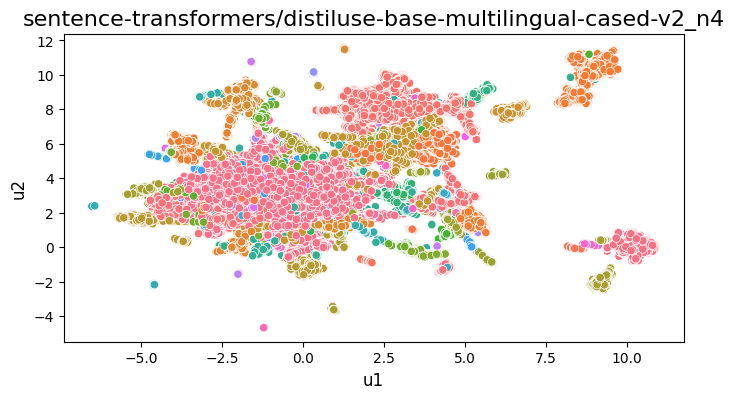

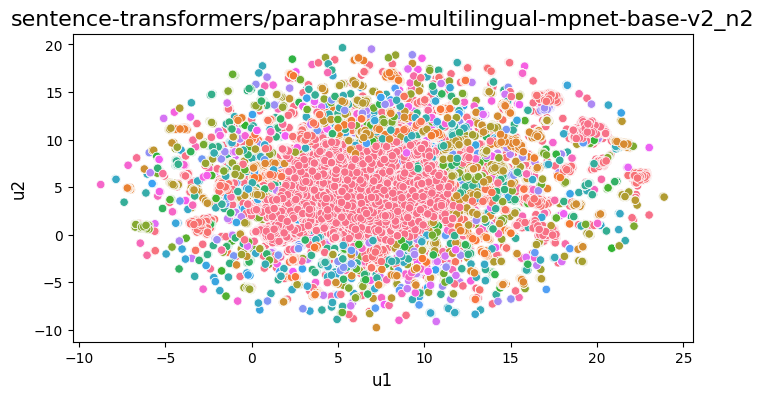

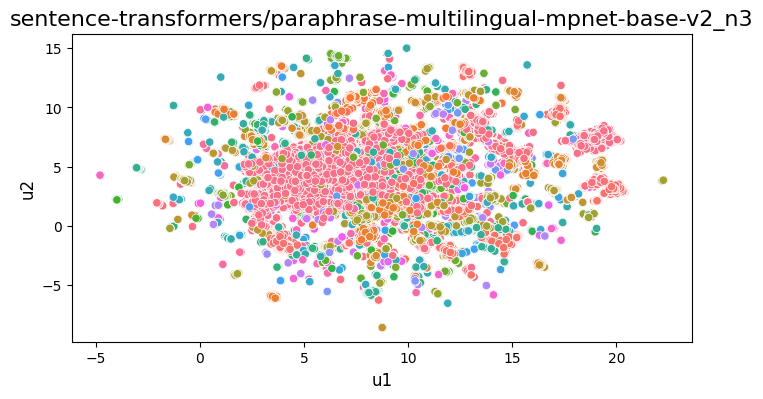

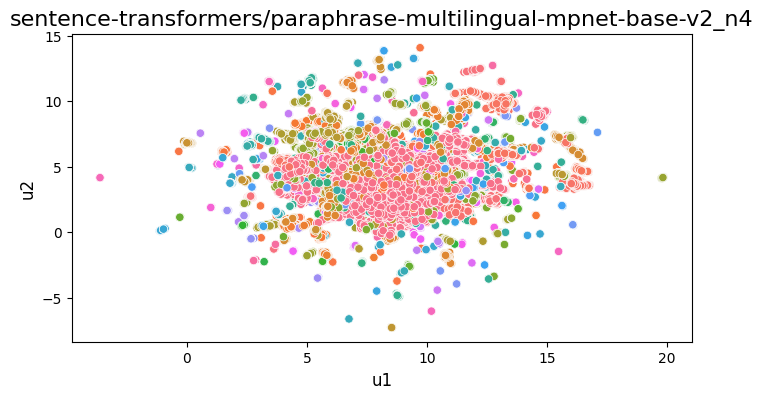

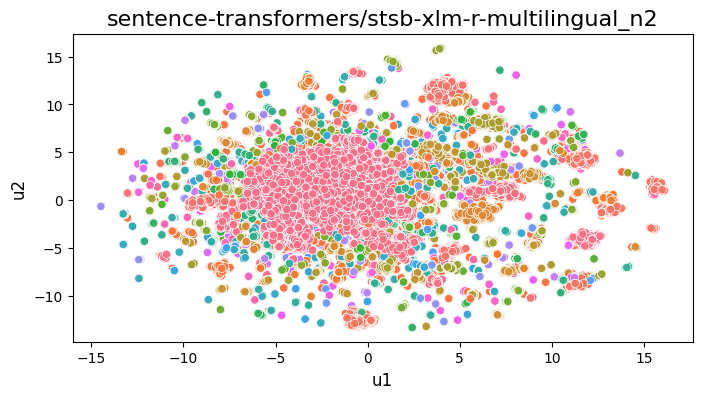

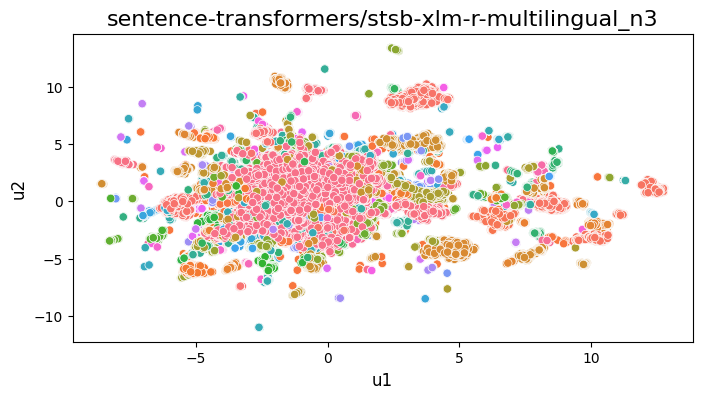

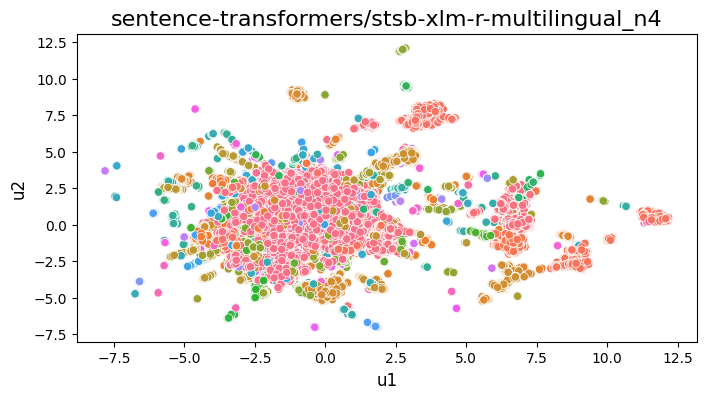

In [15]:
for m_key in MODELS:
    for n in N_COMPONENTS:
        plot_clusters2(m_key,n)

## 3.5. Очистка данных на основе содержимого

Из-за большого объема данных интерактивный график отобразить здесь не получилось.
Анализ графиков показал, что полезную информацию от шума лучше всего отделяет модель №4 'sentence-transformers/distiluse-base-multilingual-cased-v2'.
Эта модель будет использоваться далее для этапа очистки данных:

In [16]:
# Выбранная модель
selected_model=MODEL2_NAME

# Выбранное число измерений
selected_n = 4

### 3.5.1. Вывод содержимого кластеров

Выбросы удаляются после оценки содержимого для каждого из кластеров, возвращаемого алгоритмом DBSCAN. Чтобы оценить результаты, были сопоставлены 4 верхних и 4 нижних требования для каждого кластера. На основании результатов оценки было принято решение для каждого кластера, сохранить его или нет.
Результаты оцениваются на основе евклидова расстояния относительно среднего арифметического всех точек в кластере.

In [27]:
uniq_labels=np.unique(dbscan_embeddings[selected_model][selected_n].labels_)
cluster_dict={}
for cluster in uniq_labels:
    if cluster>0:
        print('--------------------------------------------')
        print("Кластер: "+str(cluster))
        item = cu.get_cluster_top_n(dbscan_embeddings[selected_model][selected_n], cluster, umap_embeddings[selected_model][selected_n], 4, df, 'canonical')
        cluster_dict[cluster]=item

--------------------------------------------
Кластер: 1
--------------------------------------------
Кластер: 2
--------------------------------------------
Кластер: 3
--------------------------------------------
Кластер: 4
--------------------------------------------
Кластер: 5
--------------------------------------------
Кластер: 6
--------------------------------------------
Кластер: 7
--------------------------------------------
Кластер: 8
--------------------------------------------
Кластер: 9
--------------------------------------------
Кластер: 10
--------------------------------------------
Кластер: 11
--------------------------------------------
Кластер: 12
--------------------------------------------
Кластер: 13
--------------------------------------------
Кластер: 14
--------------------------------------------
Кластер: 15
--------------------------------------------
Кластер: 16
--------------------------------------------
Кластер: 17
----------------------------------------

In [28]:
df_clusters = pd.DataFrame.from_dict(cluster_dict, "index")
df_clusters.reset_index(inplace=True)
df_clusters.rename(columns={'index':'cluster'}, inplace=True)

In [29]:
filename=settings.get_fresh('FILENAME_SENT_CLUSTERS')
files.save_dataframe(df_clusters, filename,MODEL_SUBDIR, to_compress=False)

'/mnt/data/projects/active/urfu/vkr/data/block_modeling/sent_clusters.csv'

### 3.5.2. Выбор кластеров для удаления
Кластер -1 содержит все точки, которые DBSCAN посчитал шумовыми - это точки, находящиеся за пределами окрестности какой-либо основной точки.
Кластер 0 является основным кластером, содержащим большинство значений без выбросов. Нет смысла оценивать их на основе их среднего значения.
Для всех остальных кластеров использовался метод get_cluster_top_n, чтобы оценить содержимое каждого кластера и принять решение о том, сохранять или удалять содержимое кластера:
Удаляемые кластеры: 2, 4, 7, 23, 43, 45, 54, 68, 101, 147, 183,184, 205, 238, 239.

### 3.5.3. Удаление кластеров

Создание столбцов в датафрейме df для визуализации результатов umap

In [34]:
embeddings[MODEL1_NAME]

array([[-0.00763226, -0.05499629, -0.1289585 , ...,  0.18264627,
        -0.08786274,  0.07242078],
       [-0.13364607, -0.01595178, -0.555017  , ...,  0.2816439 ,
        -0.26358414, -0.10185248],
       [-0.11063487,  0.09326351, -0.13620223, ...,  0.09259809,
        -0.10676032,  0.02153534],
       ...,
       [-0.32144383,  0.28816107, -0.37800378, ..., -0.08342199,
        -0.22103877, -0.09263095],
       [-0.12444406, -0.17671569, -0.3536799 , ...,  0.3463374 ,
        -0.3807417 ,  0.38832203],
       [-0.33263865, -0.2371738 ,  0.02693611, ..., -0.30249837,
        -0.21992111, -0.31256118]], dtype=float32)

In [ ]:
# for m_key in MODELS:
#     df[f'emb_{m_key}']= embeddings[m_key]
    # for n in N_COMPONENTS:
    #     df[f'umap_{m_key}_{n}_0']= [i[0] for i in umap_embeddings[m_key][n]]
    #     df[f'umap_{m_key}_{n}_1']= [i[1] for i in umap_embeddings[m_key][n]]
    #     df[f'dbscan_{m_key}_{n}_0']=dbscan_embeddings[m_key][n].labels_
    #     df[f'dbscan_{m_key}_{n}_1']=dbscan_embeddings[m_key][n].labels_.astype(str)

In [36]:
de_labels = dbscan_embeddings[selected_model][selected_n].labels_
labels_to_drop = [-1, 2, 4, 7, 23, 43, 45, 54, 68, 101, 147, 183,184, 205, 238, 239]
rows_to_drop =(np.isin(de_labels, labels_to_drop)).nonzero()[0]

In [38]:
for m_key in MODELS:
    embeddings[m_key]=np.delete(embeddings[m_key], rows_to_drop, 0)
    for n in N_COMPONENTS:
        umap_embeddings[m_key][n]=np.delete(umap_embeddings[m_key][n], rows_to_drop, 0)

In [43]:
print(f'Размер датасета до чистки: {len(requirements_dict)}')
for row in rows_to_drop:
    code=df.iloc[row,0]
    del requirements_dict[code]
print(f'Размер датасета после чистки: {len(requirements_dict)}')
print(f'Удалено: {len(rows_to_drop)}')

Размер датасета до чистки: 669431
Размер датасета после чистки: 600302
Удалено: 69129


In [45]:
filename = settings.get_fresh('FILENAME_REQUIREMENTS_TOKENIZED_CLEANED')
files.save_data_dump(requirements_dict, filename, MODEL_SUBDIR)
print('Сохранено: '+ filename)

for m_key in MODELS:
    filename = f'{m_key}_{FILENAME_EMB_SUFFIX}_cl'
    files.save_data_dump(embeddings[m_key], filename, MODEL_SUBDIR)
    print('Сохранено: '+ filename)
    for n in N_COMPONENTS:
        filename = f'{m_key}_{n}_{FILENAME_UMAP_SUFFIX}_cl'
        files.save_data_dump(umap_embeddings[m_key][n], filename, MODEL_SUBDIR)
        print('Сохранено: '+ filename)


Сохранено: requirements_tokenized_cl
Сохранено: paraphrase_minilm_l12_embeddings_cl
Сохранено: paraphrase_minilm_l12_2_umap_cl
Сохранено: paraphrase_minilm_l12_3_umap_cl
Сохранено: paraphrase_minilm_l12_4_umap_cl
Сохранено: distiluse_cased_v2_embeddings_cl
Сохранено: distiluse_cased_v2_2_umap_cl
Сохранено: distiluse_cased_v2_3_umap_cl
Сохранено: distiluse_cased_v2_4_umap_cl
Сохранено: paraphrase_mpnet_v2_embeddings_cl
Сохранено: paraphrase_mpnet_v2_2_umap_cl
Сохранено: paraphrase_mpnet_v2_3_umap_cl
Сохранено: paraphrase_mpnet_v2_4_umap_cl
Сохранено: stsb_xlm_r_embeddings_cl
Сохранено: stsb_xlm_r_2_umap_cl
Сохранено: stsb_xlm_r_3_umap_cl
Сохранено: stsb_xlm_r_4_umap_cl
